In [1]:
# 第 1 部分
# 載入函式庫與資料集
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

np.random.seed(123456)
lr = LinearRegression()

data = pd.read_csv('../Data/BTC-USD.csv')

In [9]:
# 計算變化百分比
data['diffs'] = (data.Close.diff() / data.Close.shift(periods=1,fill_value=0)).values
data['diffs'] = data['diffs'].fillna(0)

In [5]:
# (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values.shape

(1826,)

In [7]:
# (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values

array([        nan, -0.07192558, -0.06984264, ..., -0.00024111,
       -0.00099787, -0.00685359])

In [6]:
# (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values[1:].shape

(1825,)

In [8]:
# (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values[1:]

array([-0.07192558, -0.06984264,  0.03573492, ..., -0.00024111,
       -0.00099787, -0.00685359])

In [10]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,diffs
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.000000
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659


In [11]:
# 第 2 部分
# 特徵工程
# 刪除資料中的缺失值
data = data.dropna()
# 將UTC時間轉成年月日
data['Date'] = pd.to_datetime(data['Date'])
# 將時間設定為索引
data.set_index('Date', drop = True, inplace = True)
diffs = (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values[1:]
diff_len = len(diffs)

In [12]:
diff_len

1825

In [23]:
# 第 3 部分
# 建立特徵
def create_x_data(lags=1):
    diff_data = np.zeros((diff_len, lags))

    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

    return  diff_data

# 資料可重現調整
x_data = create_x_data(lags = 20) * 100 # 特徵是從當前時間點往回推算20筆比特幣收盤價變化百分比
y_data = diffs * 100                    # 標籤為從當前時間點比特幣收盤價變化百分比

x_data = np.around(x_data, decimals = 8)
y_data = np.around(y_data, decimals = 8)

In [21]:
# x_data.shape

(1825, 20)

In [15]:
# x_data

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-7.19255772,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-6.98426441, -7.19255772,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.47626776,  2.27693467,  0.61681133, ..., -1.78693977,
         2.29128897, -0.2110575 ],
       [-0.02411115, -0.47626776,  2.27693467, ..., -4.232263  ,
        -1.78693977,  2.29128897],
       [-0.09978653, -0.02411115, -0.47626776, ..., -2.50371202,
        -4.232263  , -1.78693977]])

In [22]:
# y_data.shape

(1825,)

In [16]:
# y_data

array([-7.19255772, -6.98426441,  3.57349172, ..., -0.02411115,
       -0.09978653, -0.68535866])

In [24]:
# 第 4 部分
# 訓練模型
window = 150 # 訓練資料取150筆
preds = np.zeros(diff_len - window)
for i in range(diff_len - window - 1):
    x_train = x_data[i : i + window, :]
    y_train = y_data[i : i + window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i + window + 1, :].reshape(1, -1))

print('Percentages MSE: %.2f' % 
      metrics.mean_absolute_error(y_data[window : ], preds))

Percentages MSE: 2.77


In [19]:
def simulate(data, preds):  # (模型預測值,標籤值)
    # 常數與暫存變數
    buy_threshold = 0.5 # 預測比特幣價格變化百分比大於0.5%時，且未持有比特幣則投資100元買比特幣;反之低於-0.5%以當前的收盤價出售持有的比特幣
    stake = 100

    true, pred, balances = [], [], []  # 將出售價減去購買價存在balances中

    buy_price = 0
    buy_points, sell_points = [], []
    balance = 0

    start_index = len(data) - len(preds) - 1

    # 計算預測值
    for i in range(len(preds)):
        # 昨日收盤價
        last_close = data.Close[i+start_index-1]
        # 今日收盤價
        current_close = data.Close[i+start_index]

        # 儲存今日收盤價
        true.append(current_close)
        # 儲存今日預測收盤價
        # 使用昨日收盤價跟模型預測的變化百分比換算而得
        pred.append(last_close*(1+preds[i]/100))


        # 根據預測進行交易
        # 預測會漲價並且手上沒有比特幣
        if preds[i] > buy_threshold and buy_price == 0:
            buy_price = true[-1]
            buy_points.append(i)

        # 預測會下跌且手上持有比特幣
        elif preds[i] < -buy_threshold and not buy_price == 0:
            unit = stake / buy_price
            profit = (current_close - buy_price) * unit
            balance += profit
            buy_price = 0
            sell_points.append(i)

        balances.append(balance)


    true = np.array(true)
    pred = np.array(pred)

    # 繪製圖表
    plt.figure(figsize = (8, 8))
    plt.scatter(buy_points, true[buy_points]+500, 
                marker='x', label = "buy")
    plt.scatter(sell_points, true[sell_points]-500, 
                marker='o', label = "sell", s = 5)
    plt.plot(true, label = 'True', c = 'red')
    plt.plot(pred, label = 'pred', linestyle = '--', 
             c = 'black')
    plt.title('Trades')
    plt.legend()
    plt.show()

    plt.figure(figsize = (8, 8))
    plt.plot(balances)
    plt.title('Profit')
    plt.show()
    print('MSE: %.2f'%metrics.mean_squared_error(true, pred))
    balance_df = pd.DataFrame(balances)

    pct_returns = balance_df.diff()/stake
    pct_returns = pct_returns[pct_returns != 0].dropna()


    print('Sharpe: %.2f'%
          (np.mean(pct_returns)/np.std(pct_returns)))


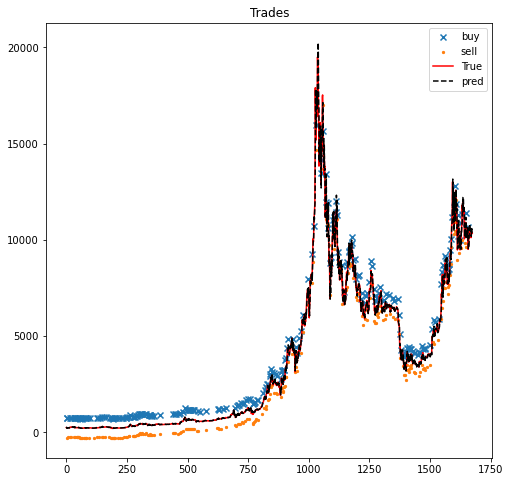

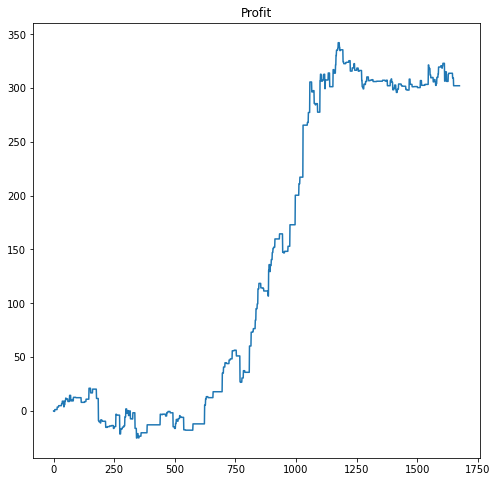

MSE: 95217.10
Sharpe: 0.16


In [20]:
simulate(data, preds) # (模型預測值,標籤值)